# Using Scikit-Learn for regression with cross validation

This tutorial uses Scikit Learn's API for training and assessing models using cross validation and covers the following topics:

* Create a scikit-learn pipeline for regression
* Training and evaluating the model using cross validation

The following cell loads the libraries:


In [1]:
import scipy.ndimage
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
import seaborn as sns

#message(Info, color=info, type=note){
This tutorial uses the house pricing dataset included with the Scikit-Learn package. The built-in datasets are useful for experimenting and learning about different models and training methods. You can find a full list of available datasets on the [Scikit-Learn documentation page](https://scikit-learn.org/stable/api/sklearn.datasets.html)

}

The current exercises uses the `pandas` library for convenience, but you don't need to study the library. Pandas dataframes are similar to numpy arrays but have named columns for easy identification. We use them only where this distinction makes the data significantly easier to work with. In the cell below the dataset is loaded and the full dataframe is extracted:


In [2]:
dataset = fetch_california_housing(as_frame=True)

df = dataset.frame # This is the dataframe (a table)
X = dataset.data # These are the input features (anything but the house price)
y = dataset.target # This contains the output features (just the house price)

print(df.describe()) # This method provides a convenient statistical summary of the columns
print('The dimensions of the dataset are:', df.shape) # Checking the shape of our dataset

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

Visualizing the data is important for understanding its structure.

The house pricing dataset consists of eight distinct features. The correlation matrix between these features is shown below: 

<Axes: >

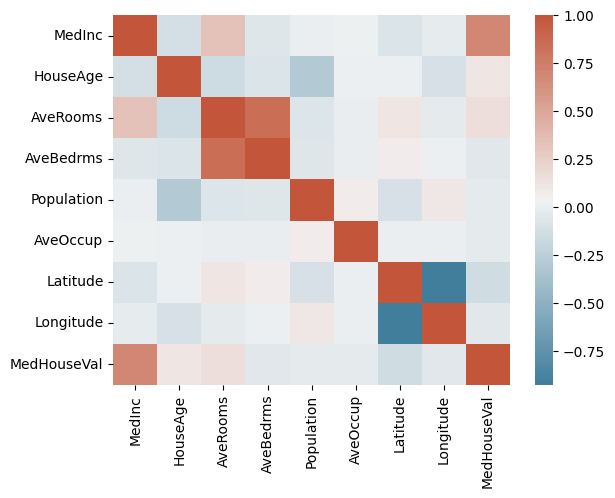

In [3]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# The Seaborn library makes complex plots like this trivial to implement.
sns.heatmap(dataset.frame.corr(), cmap=cmap)

The figure shows that median income, the average number of rooms, and the age of the houses are positively correlated with median housing prices. The strongest positive relationsip is observed between the median housing price and the median income. Latitude and longitude, which are geographic coordinates, display a negative correlation with each other. The average number of rooms shows a strong positive correlation with the average number of bedrooms (obviously). The other variables show insignificant correlations with each other, or with the target variable.


## Model and training
Scikit Learn enables model pipelines consisting of multiple steps containing multiple feature transformations (data wrangling, normalization and standardization) and trainable models. The pipeline is considered as a single model when training and testing and can be used like a standalone model as long as the last element in the pipeline is a trainable model like a regression model (`LinearRegresssion`) or a classifier (`LogisticRegresssion`). The cell below defines a pipeline for a linear regression model with polynomial features and feature normalization:

In [4]:
model = Pipeline([
    ("features", PolynomialFeatures(2)), # Calculates the design matrix for a second order polynomial
    ("normalization", Normalizer()), # Normalizes the features to a (0, 1) range. 
    ("model", LinearRegression()), # The regression model
])

The cell below fits the linear regression model to the California Housing Prices dataset, then the $R^2$ value is calculated to evaluate the model's performance. The $R^2$ value, also known as the **coefficient of determination**, will be used as the primary metric for evaluating the fit of the models. $R^2$ represents the proportion of the variance in the dependent variable (`MedHouseVal`) that is explained by the independent variables (features) in the regression model. $R^2$ is a measure of how well the model's predictions match the actual data and is calculated using the following formula:

$$
R^2 = 1 - \frac{{\sum_{i=1}^{n}(y_i - f_w(x_i))^2}}{{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$

- Explained variance: this is the numerator in the formula and is the sum of the squared differences between the predicted values and the actual values (${y_i}$). It reflects how much the model's predictions deviate from the actual data.
- Total variance: this is the denominator and represents the sum of the squared differences between the actual values $(y_i)$ and the mean of the actual values ($\bar{y}$). It shows how much the actual data itself varies.
- $R^2$: is the ratio of the explained variance to the total variance and provides a measure of the model's ability to capture the variance in the data. An $R^2$ value closer to 1 indicates a better fit, meaning the model captures a larger portion of the variance in the dependent variable.

$R^2$ is a commonly used metric to compare models to determine which model provides a better fit to the data (but it does not consider overfitting). 

In [7]:
# Fit the model to the dataset
model.fit(dataset.data, dataset.target) 
# Calculate the score on the training data
print('R-squared:',model.score(dataset.data, dataset.target))

R-squared: 0.4652803010648937


## Hold-out validation

The data is split into subsets (folds) to assess a model's generalizability. **Hold-out train-validation** divides the training data into training and validation sets containing a specific proportion of the overall data. The training set usually contains a larger proportion of the data ($70-90%$%), while the validation set contains the remaining elements. The Scikit-learn function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) implements the hold-out method. In the cell below, we use this method to split the data, then we fit the model to the training split and evaluate the model on the validation data by obtaining the $R^2$ value: 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.3, train_size=0.7)

model.fit(X_train, y_train)
print('R-squared:',model.score(X_test, y_test))

R-squared: 0.4226409952426219


Based on the output above, the model shows a poorer fit than before. The $R^2$ value decreased. Remember that due to randomly splitting the dataset, and due to variability in model perfomance, you will get a different score every time you re-run the cell above. 

## Cross validation

#block(width=100%){
#figure|calibration(
    url="material/W06/cv.png",
    caption="K-fold cross validation with five folds",
    width=500px)
}

Cross validation is a general technique used in machine learning to assess generalisation performance, by iteratively varying the training and validation subsets. Additional information is provided by changing the size of the subsets and there are multiple techniques for creating these subsets.

**K-fold cross validation** (shown in the figure above) works by splitting the dataset into $k$ folds, using $k-1$ folds for training and one for validation and not involving the test data at all. The model is trained $k$ times, such that each fold is used for validation once.

The function [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) implements k-fold cross validation. In the cell below the dataset is split into 100 equal folds with 99 folds used for training and one held out for validation (splitting into 100 folds is feasible as the dataset contains 20640 samples with each sample having a dimensionality of 9): 

In [15]:
kfold = KFold(100, shuffle=True)

results = cross_validate(
    model,
    dataset.data,
    dataset.target,
    cv=kfold,
    scoring="r2", 
    return_train_score=True,
    return_estimator=True,
)

validation_error = results["test_score"]
print('R-squared:',validation_error.mean())

R-squared: 0.41537239448915764


The model shows a level of fit that closely resembles what we obtained in the initial training setup and through the hold-out validation. A consistent and reliable model performance is observed, regardless of how the data is partitioned into folds. This can be a positive sign, indicating a good generalization ability and a consistent model performance on unseen data.

By modifying the number of folds we can change the portion of the dataset used for training and validation, and consequently change the size of both sets. A decrease in the number of folds results in a larger validation set and a smaller training set. With fewer folds (e.g., going from 20 folds to 10 folds), each validation set becomes larger, meaning that more data is reserved for testing the model’s performance. While this means the model has less training data to learn from, it also allows for more thorough testing on a larger validation set. An increase in the number of folds results in a smaller validation set and a larger training set. With more folds (e.g., going from 20 folds to 30 folds), each validation set becomes smaller, meaning that more data is used for training the model. This generally helps the model learn better patterns from a larger training set, but the smaller validation sets can lead to higher variability in the performance metrics, as these smaller sets might not fully represent the dataset’s overall distribution.
 
The cell below investigates the influence of the number of folds ($k$) on model fit:

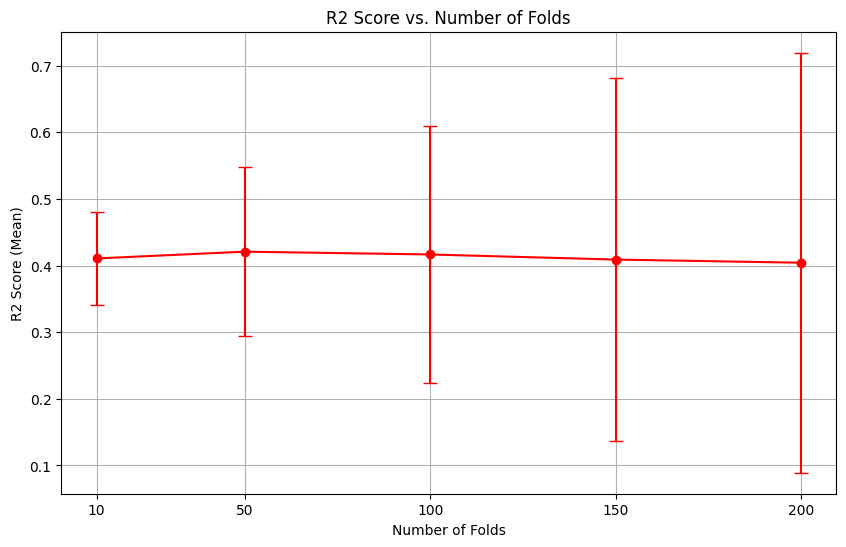

In [16]:
def k_fold_cv(k):
    kfold = KFold(n_splits=k, shuffle=True)

    return cross_validate(
        model,
        dataset.data,
        dataset.target,
        cv=kfold, # This parameter determines the number of folds
        scoring="r2", 
        return_train_score=True,
        return_estimator=True,
    )

r2_vals = []
r2_std = []
for i in [10, 50, 100, 150, 200]:
    res = k_fold_cv(i)
    r2_vals.append(res["test_score"].mean())
    r2_std.append(res["test_score"].std())


plt.figure(figsize=(10, 6))
plt.errorbar([10, 50,100, 150, 200], r2_vals, yerr=r2_std, fmt='o-', color='r', capsize=5)
plt.title('R2 Score vs. Number of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('R2 Score (Mean)')
plt.xticks([10, 50,100, 150, 200])
plt.grid(True)
plt.show()

The plot above shows that mean $R^2$ values remain relatively stable, showing that on average, the model performs well on unseen data, as 40% of the total variance of the labels is accounted for by the model. Regardless of the amount of training data or validation samples the model performs in a similar way, indicating that the model does not overfit to the data. However, the error bars (standard deviation) show a noticeable increase in variance as the number of folds increases. When the validation set is small, the estimates of model performance become less accurate, making it more likely to either overestimate or underestimate how well the model is truly performing. This variability in the validation results leads to greater differences in the $R^2$ scores across different folds. As a result, the overall variance in the $R^2$ scores increases when using more folds.

## Effects of polynomials on model fit

The cell below investigates the influence of the degree of the polynomial:

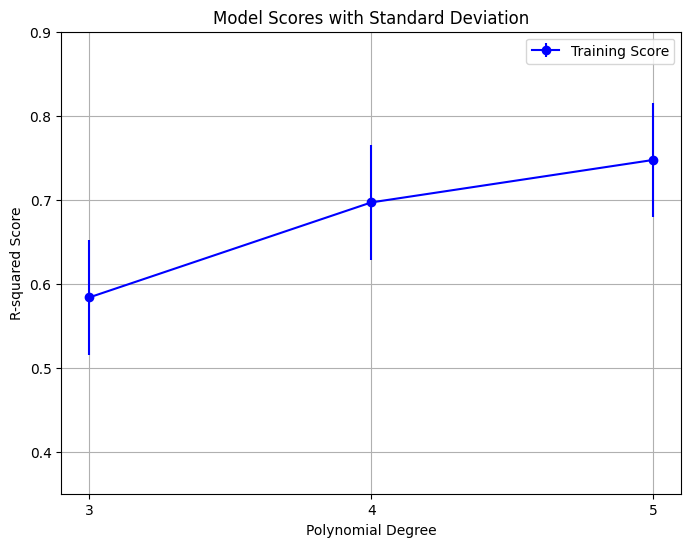

In [21]:
# Define the polynomial degrees
degrees = [3, 4, 5]

# Initialize lists to store the model scores for training and testing
train_scores = []
test_scores = []

# Loop through each polynomial degree and fit the model
for degree in degrees:
    model = Pipeline([
        ("features", PolynomialFeatures(degree)),
        ("normalization", Normalizer()),
        ("model", LinearRegression(fit_intercept=True))
    ])
    
    model.fit(X_train, y_train)
    
    # Calculate the R-squared score for training data
    train_score = model.score(X_train, y_train)
    train_scores.append(train_score)
    
    # Calculate the R-squared score for testing data
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

    # Calculate standard deviations of training and testing scores
    train_std = np.std(train_scores)
    test_std = np.std(test_scores)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.errorbar(degrees, train_scores, yerr=train_std, label='Training Score', marker='o', linestyle='-', color='b')
plt.title('Model Scores with Standard Deviation')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared Score')
plt.legend()
plt.grid(True)
plt.xticks(degrees)
plt.ylim(0.35, 0.9)  # Adjust the y-axis limits if needed
plt.show()

As illustrated in the plot, increasing the degree of the polynomial results in the model fitting the training data increasingly better and the variance remains about the same. The cell below examines the model's performance on the validation set which can give us a deeper insight into the actual predictive power of the model:

In [22]:
print(test_scores)

[-0.36099273790557307, -1076.168645487712, -69756807.79916742]


The R-squared values for the three polynomials are negative, indicating that regression model is exceptionally poor. In fact a negative R-squared value implies that our predictions would be more accurate by simply predicting the mean of the label variable, rather than using the regression model. The reason is that with a polynomial degree higher than 2, the model is overfitting the data and becomes overly sensitive to noise within the data rather than capturing the underlying trend.